In [72]:
import os
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

In [73]:
def get_files(folder):
    filenames = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".png") and "imgs" in root:
                filenames.append(os.path.join(root, file))
    return filenames


files = get_files("data/")
train_paths = [(path, path.replace("imgs", "targets")) for path in files if "train" in path]
test_paths = [(path, path.replace("imgs", "targets")) for path in files if "test" in path]
val_paths = [(path, path.replace("imgs", "targets")) for path in files if "valid" in path]

print("Number of training samples: ", len(train_paths),
      "\nNumber of validation samples: ", len(val_paths),
      "\nNumber of test samples: ", len(test_paths))


Number of training samples:  320 
Number of validation samples:  91 
Number of test samples:  47


In [74]:

def normalize_image(image):
    image = tf.cast(image, tf.float32) - tf.reduce_mean(image)
    image = image / tf.math.reduce_std(image)
    return image


def normalize_mask(mask):
    mask = tf.cast(mask, tf.float32)
    mask = mask / 255.0
    return mask


def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, IMSIZE)
    return image


def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMSIZE)
    return mask


def load_image_pair(image_path):
    image = load_image(image_path[0])
    mask = load_mask(image_path[1])
    image = normalize_image(image)
    mask = normalize_mask(mask)
    return image, mask


import tensorflow.keras.backend as K


@tf.function
def dice(y_true, y_pred):
    """Computes the Dice loss value between `y_true` and `y_pred`.

    Formula:
    ```python
    loss = 1 - (2 * sum(y_true * y_pred)) / (sum(y_true) + sum(y_pred))
    ```

    Args:
        y_true: tensor of true targets.
        y_pred: tensor of predicted targets.

    Returns:
        Dice loss value.
    """
    y_true = K.cast(y_true, y_pred.dtype)

    inputs = K.flatten(y_true)
    targets = K.flatten(y_pred)

    intersection = K.sum(inputs * targets)
    dice = tf.divide(
        2.0 * intersection,
        K.sum(y_true) + K.sum(y_pred) + K.epsilon(),
    )

    return 1 - dice


@tf.function
def dice_metric(y_true, y_pred):
    """Computes the Dice loss value between `y_true` and `y_pred`.

    Formula:
    ```python
    loss = 1 - (2 * sum(y_true * y_pred)) / (sum(y_true) + sum(y_pred))
    ```

    Args:
        y_true: tensor of true targets.
        y_pred: tensor of predicted targets.

    Returns:
        Dice loss value.
    """
    y_true = K.cast(y_true, y_pred.dtype)

    inputs = K.flatten(y_true)
    targets = K.flatten(y_pred)

    intersection = K.sum(inputs * targets)
    dice = tf.divide(
        2.0 * intersection,
        K.sum(y_true) + K.sum(y_pred) + K.epsilon(),
    )

    return dice

In [75]:
# Create the dataset
BUFFER_SIZE = 100
BATCH_SIZE = 16
IMSIZE = (256, 256)


def create_dataset(paths):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.map(load_image_pair, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    batches = (
        dataset
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )
    return batches


train_batches = create_dataset(train_paths)
test_batches = create_dataset(test_paths)
val_batches = create_dataset(val_paths)

In [76]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model

default_args = {
    "kernel_initializer": "he_normal",
    "padding": "same",
    "activation": "relu"
}


def model_builder(hp):
    dropout = hp.Float('dropout', 0.15, 0.35, step=0.05)
    lr = hp.Float('learning_rate', 2e-4, 14e-4, sampling='log')
    units = hp.Int('units', min_value=40, max_value=96, step=8)
    
    # Rest of the model
    ...
    
    
    
    
    
    in1 = Input(shape=(*IMSIZE, 1))

    conv1 = Conv2D(units * 1, (3, 3), **default_args)(in1)
    conv1 = Dropout(dropout)(conv1)
    conv1 = Conv2D(units * 1, (3, 3), **default_args)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(units * 2, (3, 3), **default_args)(pool1)
    conv2 = Dropout(dropout)(conv2)
    conv2 = Conv2D(units * 2, (3, 3), **default_args)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(units * 4, (3, 3), **default_args)(pool2)
    conv3 = Dropout(dropout)(conv3)
    conv3 = Conv2D(units * 4, (3, 3), **default_args)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(units * 4, (3, 3), **default_args)(pool3)
    conv4 = Dropout(dropout)(conv4)
    conv4 = Conv2D(units * 4, (3, 3), **default_args)(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(units * 2, (3, 3), **default_args)(up1)
    conv5 = Dropout(dropout)(conv5)
    conv5 = Conv2D(units * 2, (3, 3), **default_args)(conv5)

    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(units * 2, (3, 3), **default_args)(up2)
    conv6 = Dropout(dropout)(conv6)
    conv6 = Conv2D(units * 2, (3, 3), **default_args)(conv6)

    up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(units, (3, 3), **default_args)(up2)
    conv7 = Dropout(dropout)(conv7)
    conv7 = Conv2D(units, (3, 3), **default_args)(conv7)
    segmentation = Conv2D(1, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=dice,
                  metrics=['accuracy', dice_metric])
    return model

In [77]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('val_dice_metric', direction="max"),
                     max_epochs=150,
                     factor=3,
                     hyperband_iterations=1,
                     directory='hp_tuning',
                     project_name='tuning_2',
                     overwrite=False
                     )
tuner.search_space_summary(extended=True)

Reloading Tuner from hp_tuning\tuning_2\tuner0.json
Search space summary
Default search space size: 3
dropout (Float)
{'default': 0.15, 'conditions': [], 'min_value': 0.15, 'max_value': 0.35, 'step': 0.05, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0002, 'conditions': [], 'min_value': 0.0002, 'max_value': 0.0014, 'step': None, 'sampling': 'log'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 96, 'step': 8, 'sampling': 'linear'}


In [78]:
tuner.search(train_batches,
             validation_data=val_batches,
             epochs=150,
             verbose=2,
             callbacks=[tf.keras.callbacks.TensorBoard("logs/fit4/")])

Trial 247 Complete [00h 05m 20s]
val_dice_metric: 0.9643349051475525

Best val_dice_metric So Far: 0.9657557606697083
Total elapsed time: 04h 14m 12s

Search: Running Trial #248

Value             |Best Value So Far |Hyperparameter
0.3               |0.2               |dropout
0.00024283        |0.00062329        |learning_rate
80                |48                |units
150               |150               |tuner/epochs
50                |50                |tuner/initial_epoch
1                 |4                 |tuner/bracket
1                 |4                 |tuner/round
0236              |0142              |tuner/trial_id

Epoch 51/150
20/20 - 11s - loss: 0.0322 - accuracy: 0.9946 - dice_metric: 0.9678 - val_loss: 0.0488 - val_accuracy: 0.9922 - val_dice_metric: 0.9497 - 11s/epoch - 543ms/step
Epoch 52/150
20/20 - 8s - loss: 0.0313 - accuracy: 0.9947 - dice_metric: 0.9687 - val_loss: 0.0441 - val_accuracy: 0.9929 - val_dice_metric: 0.9563 - 8s/epoch - 394ms/step
Epoch 53/150
20

KeyboardInterrupt: 

In [79]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print("units: ", best_hps.get('units'))
print("learning rate: ", best_hps.get('learning_rate'))
print("dropout: ", best_hps.get('dropout'))

Best hyperparameters:
units:  48
learning rate:  0.0006232906288344095
dropout:  0.2


In [80]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_batches,
                    validation_data=val_batches,
                    epochs=150,
                    verbose=2)

Epoch 1/150
20/20 - 5s - loss: 0.8137 - accuracy: 0.4734 - dice_metric: 0.1863 - val_loss: 0.7966 - val_accuracy: 0.4599 - val_dice_metric: 0.2036 - 5s/epoch - 242ms/step
Epoch 2/150
20/20 - 4s - loss: 0.7915 - accuracy: 0.5025 - dice_metric: 0.2085 - val_loss: 0.7910 - val_accuracy: 0.4884 - val_dice_metric: 0.2088 - 4s/epoch - 190ms/step
Epoch 3/150
20/20 - 4s - loss: 0.7528 - accuracy: 0.6348 - dice_metric: 0.2472 - val_loss: 0.6601 - val_accuracy: 0.8015 - val_dice_metric: 0.3403 - 4s/epoch - 190ms/step
Epoch 4/150
20/20 - 4s - loss: 0.6193 - accuracy: 0.8566 - dice_metric: 0.3807 - val_loss: 0.5903 - val_accuracy: 0.8430 - val_dice_metric: 0.4099 - 4s/epoch - 192ms/step
Epoch 5/150
20/20 - 4s - loss: 0.5534 - accuracy: 0.8886 - dice_metric: 0.4466 - val_loss: 0.5401 - val_accuracy: 0.8714 - val_dice_metric: 0.4610 - 4s/epoch - 190ms/step
Epoch 6/150
20/20 - 4s - loss: 0.5065 - accuracy: 0.9025 - dice_metric: 0.4935 - val_loss: 0.4819 - val_accuracy: 0.8992 - val_dice_metric: 0.518

(256, 256, 1) (256, 256, 1)
2.0453367 1.0
-1.5999825 0.0
(256, 256, 1) (256, 256, 1)
2.1488938 1.0
-1.8279128 0.0


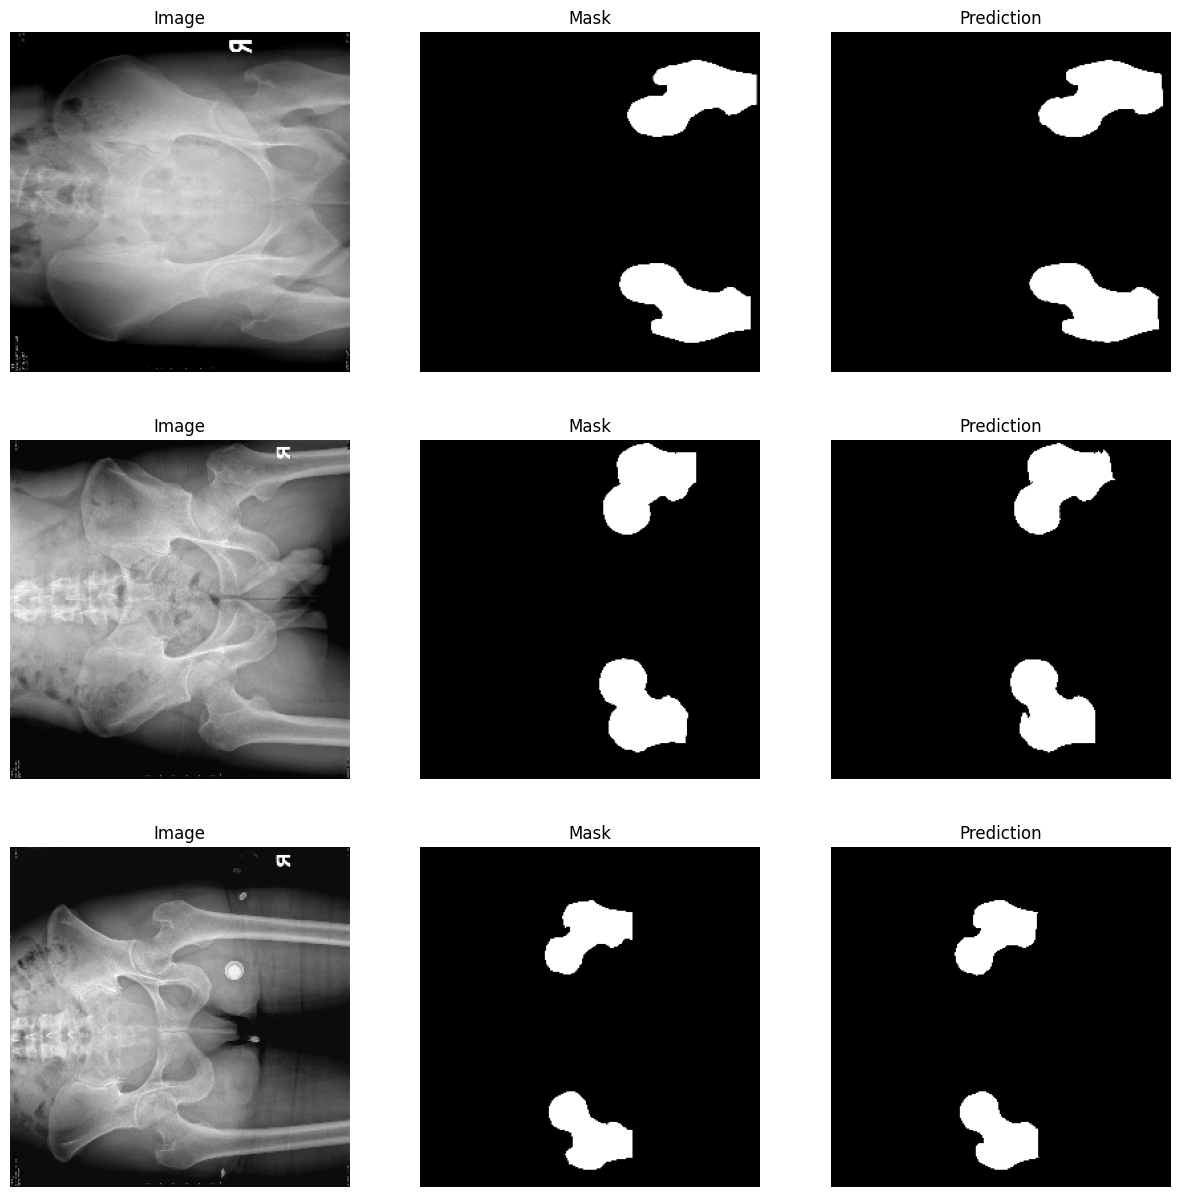

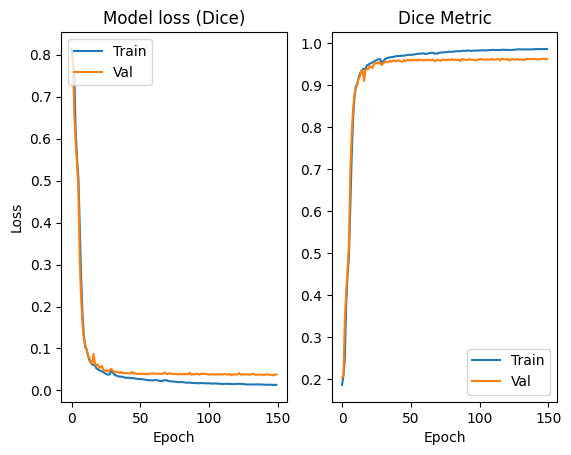

In [81]:
import numpy as np
for images, masks in test_batches.take(1):
    predictions = model.predict(images)
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    for ii, (img, msk, prediction) in enumerate(zip(images, masks, predictions)):
        axs[ii, 0].imshow(img, cmap='gray')
        axs[ii, 1].imshow(msk, cmap='gray')
        axs[ii, 2].imshow(prediction, cmap='gray')
        axs[ii, 0].axis("off")
        axs[ii, 1].axis("off")
        axs[ii, 2].axis("off")
        axs[ii, 0].set_title("Image")
        axs[ii, 1].set_title("Mask")
        axs[ii, 2].set_title("Prediction")
        if ii == 2:
            break

        print(img.shape, msk.shape)
        print(np.max(img), np.max(msk))
        print(np.min(img), np.min(msk))

fig, axs = plt.subplots(1, 2)
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[1].plot(history.history['dice_metric'])
axs[1].plot(history.history['val_dice_metric'])
axs[0].set_title('Model loss (Dice)')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Val'], loc='upper left')
axs[1].set_title('Dice Metric')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Val'], loc='lower right')
plt.show()